## Environment Prerequisites

Before using this project, ensure you have the following:

Python Environment:

Python version 3.7 or above is recommended.
Dependencies: Install the required Python libraries using the command below.

Installation
1. Set Up Virtual Environment (Optional but Recommended) 
python -m venv myenv 
source myenv/bin/activate  
On Windows use `myenv\Scripts\activate` 

2. Install Required Libraries
Run the following command to install all necessary libraries: 

3. Install the LLM Dependency

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import json
import re
import time
import numpy as np
from scipy.stats import entropy
from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance
from scipy.stats import chi2_contingency, pearsonr
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, chisquare, energy_distance
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import rbf_kernel

In [ ]:
pip install openai==0.28
pip install transformers

In [ ]:
!pip install pandas matplotlib seaborn openai scipy numpy

## Prompts

### Few-Shot Prompting

In [ ]:
import openai
import pandas as pd
import json
import re
import time

# Set your API key
openai.api_key = API_KEY

# Combine the system and user prompts into a single message
combined_message = {
    "role": "user",
    "content": """
You are a data scientist generating synthetic heart disease records.
Here are a few examples of how the data looks:

age sex  dataset         cp         trestbps   chol   fbs   restecg           thalach  exang   oldpeak slope         ca    thal                target
63 Male Cleveland  typical angina    145       233  TRUE  lv hypertrophy       150    FALSE     2.3    downsloping  0    fixed defect          0
67 Male Cleveland  asymptomatic      160       286  FALSE lv hypertrophy       108    TRUE      1.5    flat         3    normal                1
67 Male Cleveland  asymptomatic      120       229  FALSE lv hypertrophy       129    TRUE      2.6    flat         2    reversible defect     1
37 Male Cleveland  non-anginal       130       250  FALSE    normal            187    FALSE     3.5    downsloping  0    normal                0
41 Female Cleveland atypical angina  130       204  FALSE lv hypertrophy       172    FALSE     1.4    upsloping    0    normal                0

Now, generate a new synthetic record in JSON format with the following structure. Please output only the JSON data without any additional text.

{
  "age": [number between 30 and 80],
  "sex": "Male" or "Female",
  "dataset": "Cleveland",
  "cp": "typical angina", "atypical angina", "non-anginal pain", or "asymptomatic",
  "trestbps": [number between 90 and 180],
  "chol": [number between 100 and 400],
  "fbs": true or false,
  "restecg": "lv hypertrophy", "normal", or "st-t abnormality",
  "thalach": [number between 70 and 200],
  "exang": true or false,
  "oldpeak": [number between 0.0 and 6.0],
  "slope": "upsloping", "flat", or "downsloping",
  "ca": [integer between 0 and 4],
  "thal": "normal", "fixed defect", or "reversible defect",
  "target": 1 or 0
}
"""
}

# Function to generate a synthetic heart disease record using chat completion
def generate_synthetic_data():
    response = openai.ChatCompletion.create(
    model="gpt-4",  
    messages=[combined_message],
    max_tokens=150,
    temperature=0.7,
    top_p=0.9
    )
    
    # Accumulate tokens used in each call
    prompt_tokens = response['usage']['prompt_tokens']
    completion_tokens = response['usage']['completion_tokens']
    total_tokens = response['usage']['total_tokens']

    return response['choices'][0]['message']['content'].strip(), prompt_tokens, completion_tokens, total_tokens

# Initialize counters for data points and tokens
total_data_points = 0
total_prompt_tokens = 0
total_completion_tokens = 0
total_tokens_used = 0

# Generate and store records in a dataset
records = []
while total_data_points < 50:  # Stop when 50 records are generated
    synthetic_data, prompt_tokens, completion_tokens, total_tokens = generate_synthetic_data()
    
    # Update counters
    total_data_points += 1
    total_prompt_tokens += prompt_tokens
    total_completion_tokens += completion_tokens
    total_tokens_used += total_tokens

    # Parse and store the JSON data
    json_match = re.search(r'\{.*\}', synthetic_data, re.DOTALL)
    if json_match:
        json_data = json_match.group(0)
        try:
            data_dict = json.loads(json_data)
            records.append(data_dict)
        except json.JSONDecodeError:
            print("Skipping record due to JSON parsing error.")
    else:
        print("Skipping record due to JSON format error.")

# Create a DataFrame and save to CSV if we have valid records
if records:
    df = pd.DataFrame(records)
    output_file = "synthetic_few_shots_default.csv"
    df.to_csv(output_file, index=False)
    print(f"Synthetic data saved to {output_file}")
else:
    print("No valid records generated.")

# Print summary of total data points and tokens used
print(f"Total Data Points: {total_data_points}")
print(f"Total Prompt Tokens: {total_prompt_tokens}")
print(f"Total Completion Tokens: {total_completion_tokens}")
print(f"Total Tokens Used: {total_tokens_used}")


Synthetic data saved to synthetic_few_shots_default.csv
Total Data Points: 50
Total Prompt Tokens: 25900
Total Completion Tokens: 6191
Total Tokens Used: 32091


### Chain-of-Thought Prompting

In [ ]:
import openai
import pandas as pd
import json
import re
import time

# Set your API key
openai.api_key = API_KEY  

# Combine the system and user prompts into a single message
combined_message = {
    "role": "user",
    "content": """
You are a data scientist generating synthetic heart disease records. Please generate each data field step-by-step based on the constraints and considerations below.

Let's go through each field in a structured way:
1. **age**: Choose a realistic age between 30 and 80.
2. **sex**: Randomly select either "Male" or "Female".
3. **dataset**: Set this field to "Cleveland".
4. **cp** (chest pain type): Randomly select one of the following:
   - "typical angina", "atypical angina", "non-anginal pain", or "asymptomatic".
5. **trestbps** (resting blood pressure): Choose a realistic number between 90 and 180.
6. **chol** (cholesterol level): Select a realistic cholesterol value between 100 and 400.
7. **fbs** (fasting blood sugar): Randomly assign this as true or false.
8. **restecg** (resting electrocardiographic results): Choose one of the following:
   - "lv hypertrophy", "normal", or "st-t abnormality".
9. **thalach** (maximum heart rate achieved): Select a realistic value between 70 and 200.
10. **exang** (exercise-induced angina): Randomly assign this as true or false.
11. **oldpeak**: Select a value between 0.0 and 6.0 to represent ST depression induced by exercise relative to rest.
12. **slope**: Choose one of the following for the slope of the peak exercise ST segment:
   - "upsloping", "flat", or "downsloping".
13. **ca** (number of major vessels): Choose an integer between 0 and 4.
14. **thal**: Randomly select one of the following:
   - "normal", "fixed defect", or "reversible defect".
15. **target**: Randomly assign either 1 or 0 to indicate presence or absence of disease.

Now, based on this structure, generate a new synthetic record in JSON format with the following structure. Please output only the JSON data without any additional text.

{
  "age": [number between 30 and 80],
  "sex": "Male" or "Female",
  "dataset": "Cleveland",
  "cp": "typical angina", "atypical angina", "non-anginal pain", or "asymptomatic",
  "trestbps": [number between 90 and 180],
  "chol": [number between 100 and 400],
  "fbs": true or false,
  "restecg": "lv hypertrophy", "normal", or "st-t abnormality",
  "thalach": [number between 70 and 200],
  "exang": true or false,
  "oldpeak": [number between 0.0 and 6.0],
  "slope": "upsloping", "flat", or "downsloping",
  "ca": [integer between 0 and 4],
  "thal": "normal", "fixed defect", or "reversible defect",
  "target": 1 or 0
}
"""
}

# Function to generate a synthetic heart disease record using chat completion
def generate_synthetic_data():
    response = openai.ChatCompletion.create(
    model="gpt-4",  
    messages=[combined_message],
    max_tokens=150,
    temperature=0.7,
    top_p=0.9
    )
    
    # Accumulate tokens used in each call
    prompt_tokens = response['usage']['prompt_tokens']
    completion_tokens = response['usage']['completion_tokens']
    total_tokens = response['usage']['total_tokens']

    return response['choices'][0]['message']['content'].strip(), prompt_tokens, completion_tokens, total_tokens

# Initialize counters for data points and tokens
total_data_points = 0
total_prompt_tokens = 0
total_completion_tokens = 0
total_tokens_used = 0

# Generate and store records in a dataset
records = []
while total_data_points < 50:  # Stop when 50 records are generated
    synthetic_data, prompt_tokens, completion_tokens, total_tokens = generate_synthetic_data()
    
    # Update counters
    total_data_points += 1
    total_prompt_tokens += prompt_tokens
    total_completion_tokens += completion_tokens
    total_tokens_used += total_tokens

    # Parse and store the JSON data
    json_match = re.search(r'\{.*\}', synthetic_data, re.DOTALL)
    if json_match:
        json_data = json_match.group(0)
        try:
            data_dict = json.loads(json_data)
            records.append(data_dict)
        except json.JSONDecodeError:
            print("Skipping record due to JSON parsing error.")
    else:
        print("Skipping record due to JSON format error.")

# Create a DataFrame and save to CSV if we have valid records
if records:
    df = pd.DataFrame(records)
    output_file = "synthetic_CoT_default.csv"
    df.to_csv(output_file, index=False)
    print(f"Synthetic data saved to {output_file}")
else:
    print("No valid records generated.")

# Print summary of total data points and tokens used
print(f"Total Data Points: {total_data_points}")
print(f"Total Prompt Tokens: {total_prompt_tokens}")
print(f"Total Completion Tokens: {total_completion_tokens}")
print(f"Total Tokens Used: {total_tokens_used}")


Synthetic data saved to synthetic_CoT_default.csv
Total Data Points: 50
Total Prompt Tokens: 34050
Total Completion Tokens: 6138
Total Tokens Used: 40188


## Synthetic Data

#### Few Shots

In [7]:
df_FewShots = pd.read_csv("synthetic_few_shots_default.csv")
df_FewShots.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,45,Male,Cleveland,non-anginal pain,130,220,False,st-t abnormality,150,True,1.2,flat,2,reversible defect,1
1,45,Female,Cleveland,non-anginal pain,135,275,False,normal,155,True,2.1,flat,1,reversible defect,0
2,56,Male,Cleveland,non-anginal pain,130,250,False,normal,150,True,1.2,flat,2,reversible defect,1
3,55,Male,Cleveland,non-anginal pain,130,250,False,normal,150,True,2.0,flat,1,reversible defect,1
4,55,Female,Cleveland,non-anginal pain,120,250,True,normal,140,False,1.2,flat,1,reversible defect,0


#### Chain of Thought 

In [18]:
df_CoT = pd.read_csv("synthetic_CoT_default.csv")
df_CoT.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,55,Female,Cleveland,atypical angina,130,250,False,normal,150,True,2.1,flat,2,reversible defect,1
1,67,Female,Cleveland,atypical angina,135,235,False,normal,165,True,1.2,flat,2,reversible defect,0
2,56,Female,Cleveland,asymptomatic,145,283,False,lv hypertrophy,156,True,2.3,downsloping,1,reversible defect,0
3,56,Male,Cleveland,atypical angina,140,245,False,normal,170,True,2.1,flat,1,reversible defect,1
4,67,Male,Cleveland,atypical angina,130,265,False,normal,155,True,3.5,downsloping,2,reversible defect,1


## Evaluation Metrics

### Few Shots Evaluation

In [10]:
# Define column types
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']
binary_cols = ['fbs', 'exang']

# Ensure consistent data types
for col in binary_cols:
    df[col] = df[col].astype(bool)
    df_FewShots[col] = df_FewShots[col].astype(bool)

# Preprocessing: Encode categorical variables
def preprocess_data(df):
    df_processed = df.copy()
    le_dict = {}
    for col in df_processed.columns:
        if df_processed[col].dtype == 'object' or df_processed[col].dtype == 'bool':
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col].astype(str))
            le_dict[col] = le
    return df_processed, le_dict

original_processed, le_dict_original = preprocess_data(df)
synthetic_processed, le_dict_synthetic = preprocess_data(df_FewShots)

# Ensure columns are in the same order
synthetic_processed = synthetic_processed[original_processed.columns]


1) Kolmogorov-Smirnov Test and Wasserstein Distance for Numerical Variables

/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/3581421116.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_df[col], label='Original', shade=True)
/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/3581421116.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_FewShots[col], label='Synthetic', shade=True)


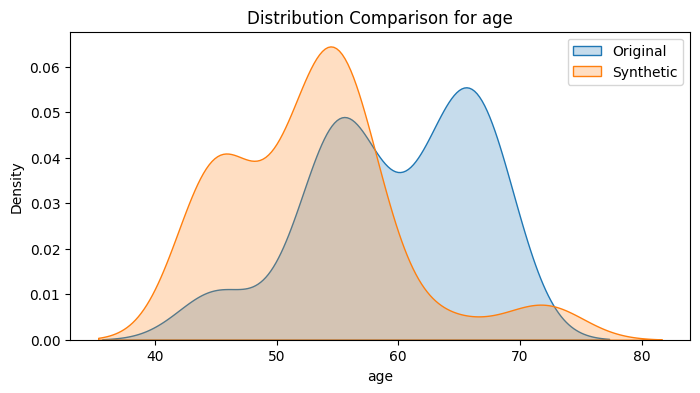

/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/3581421116.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_df[col], label='Original', shade=True)
/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/3581421116.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_FewShots[col], label='Synthetic', shade=True)


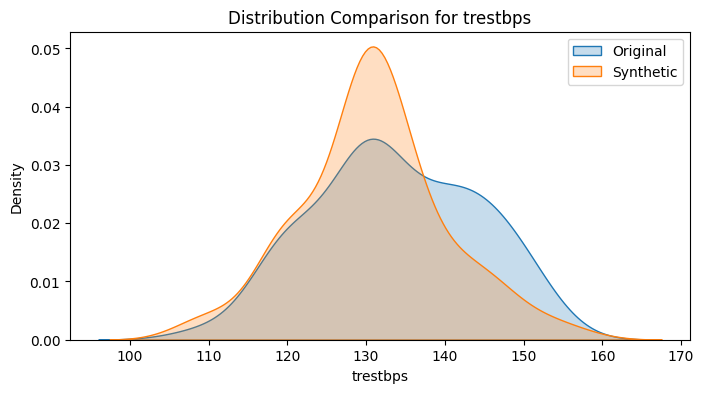

/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/3581421116.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_df[col], label='Original', shade=True)
/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/3581421116.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_FewShots[col], label='Synthetic', shade=True)


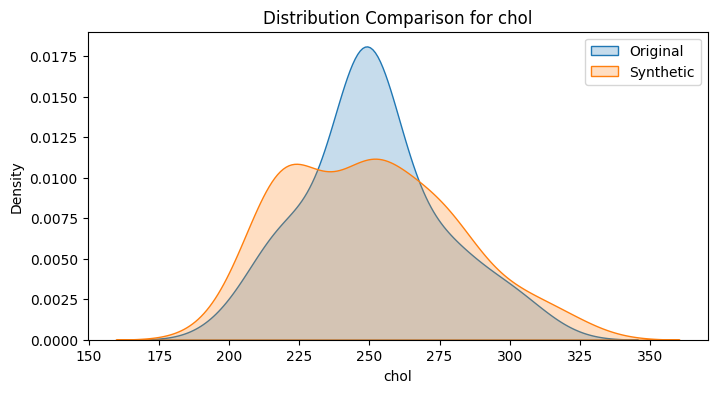

/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/3581421116.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_df[col], label='Original', shade=True)
/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/3581421116.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_FewShots[col], label='Synthetic', shade=True)


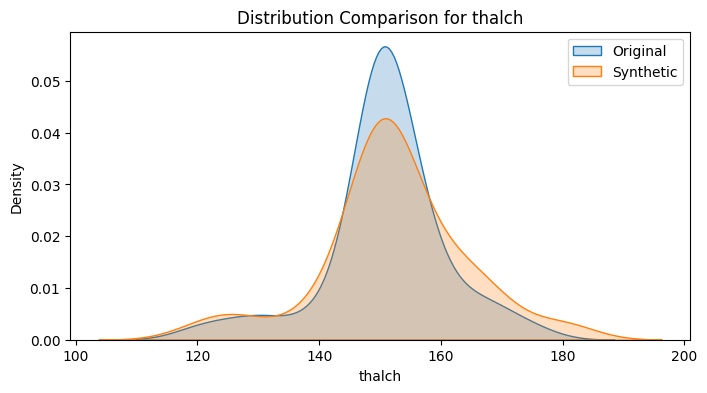

/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/3581421116.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_df[col], label='Original', shade=True)
/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/3581421116.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_FewShots[col], label='Synthetic', shade=True)


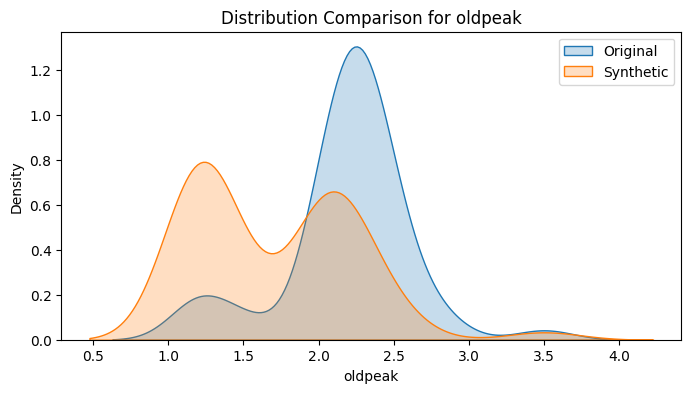

/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/3581421116.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_df[col], label='Original', shade=True)
/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/3581421116.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_FewShots[col], label='Synthetic', shade=True)


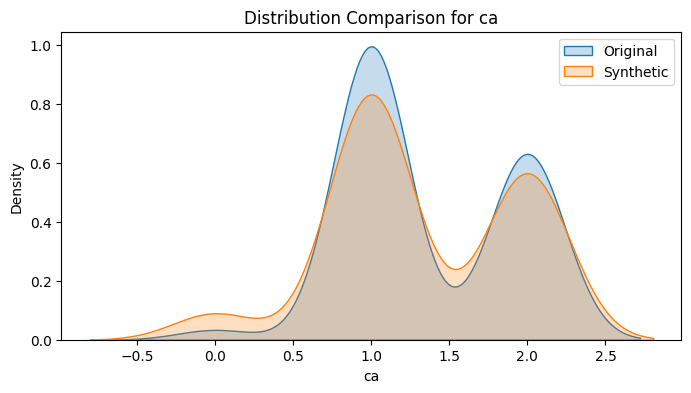

     Column  KS Statistic  KS p-value  Wasserstein Distance
0       age          0.44    0.000099                 7.160
1  trestbps          0.22    0.178587                 3.060
2      chol          0.18    0.395940                 6.100
3    thalch          0.12    0.869262                 1.920
4   oldpeak          0.48    0.000014                 0.482
5        ca          0.04    1.000000                 0.040


In [11]:
def compare_numerical_distributions(original_df, df_FewShots, columns):
    distribution_metrics = []
    for col in columns:
        ks_stat, ks_p_value = ks_2samp(original_df[col], df_FewShots[col])
        wd = wasserstein_distance(original_df[col], df_FewShots[col])
        distribution_metrics.append({
            'Column': col,
            'KS Statistic': ks_stat,
            'KS p-value': ks_p_value,
            'Wasserstein Distance': wd
        })
        # Plot distributions
        plt.figure(figsize=(8, 4))
        sns.kdeplot(original_df[col], label='Original', shade=True)
        sns.kdeplot(df_FewShots[col], label='Synthetic', shade=True)
        plt.title(f'Distribution Comparison for {col}')
        plt.legend()
        plt.show()
    return pd.DataFrame(distribution_metrics)

numerical_distribution_metrics = compare_numerical_distributions(
    original_processed, synthetic_processed, numerical_cols)
print(numerical_distribution_metrics)

2) Machine Learning Utility Metrics
a. Train on Synthetic, Test on Original
b. Train on Original, Test on Synthetic

TRAIN ON SYNTHETIC, TEST ON ORIGINAL Evaluation:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.82      0.82      0.82        11

    accuracy                           0.73        15
   macro avg       0.66      0.66      0.66        15
weighted avg       0.73      0.73      0.73        15

TRAIN ON ORIGINAL, TEST ON SYNTHETIC Evaluation:
              precision    recall  f1-score   support

           0       0.59      0.77      0.67        31
           1       0.22      0.11      0.14        19

    accuracy                           0.52        50
   macro avg       0.40      0.44      0.40        50
weighted avg       0.45      0.52      0.47        50



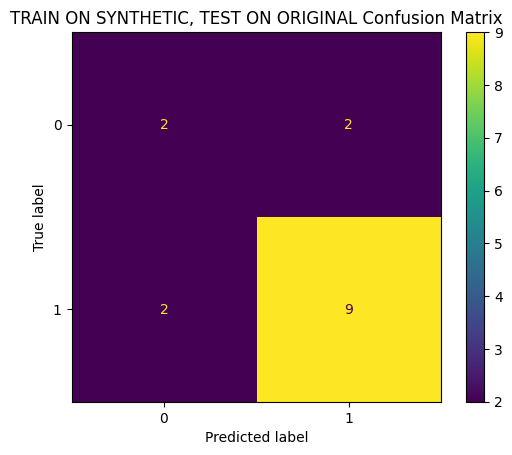

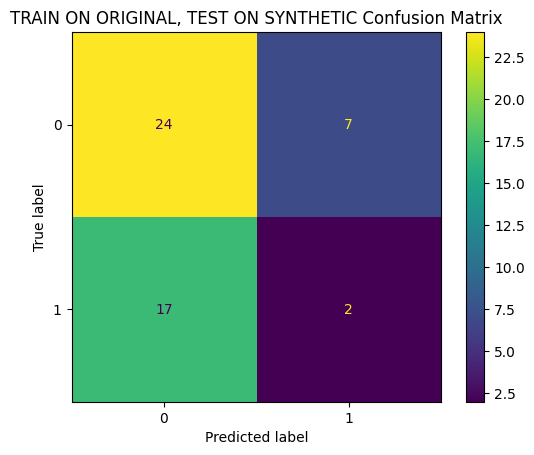

In [12]:
# Define target and features
target_column = 'num'
feature_columns = [col for col in original_processed.columns if col != target_column]

# Split the original data
X_orig = original_processed[feature_columns]
y_orig = original_processed[target_column]
X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(
    X_orig, y_orig, test_size=0.3, random_state=42)

# Prepare synthetic data
X_synth = synthetic_processed[feature_columns]
y_synth = synthetic_processed[target_column]

# TSTR: Train on Synthetic, Test on Original
model_tstr = RandomForestClassifier(n_estimators=100, random_state=42)
model_tstr.fit(X_synth, y_synth)
y_pred_tstr = model_tstr.predict(X_orig_test)
print("TRAIN ON SYNTHETIC, TEST ON ORIGINAL Evaluation:")
print(classification_report(y_orig_test, y_pred_tstr))

# TSOR: Train on Original, Test on Synthetic
model_tsor = RandomForestClassifier(n_estimators=100, random_state=42)
model_tsor.fit(X_orig_train, y_orig_train)
y_pred_tsor = model_tsor.predict(X_synth)
print("TRAIN ON ORIGINAL, TEST ON SYNTHETIC Evaluation:")
print(classification_report(y_synth, y_pred_tsor))

# Plot confusion matrices
# TSTR Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_orig_test, y_pred_tstr)
plt.title('TRAIN ON SYNTHETIC, TEST ON ORIGINAL Confusion Matrix')
plt.show()

# TSOR Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_synth, y_pred_tsor)
plt.title('TRAIN ON ORIGINAL, TEST ON SYNTHETIC Confusion Matrix')
plt.show()

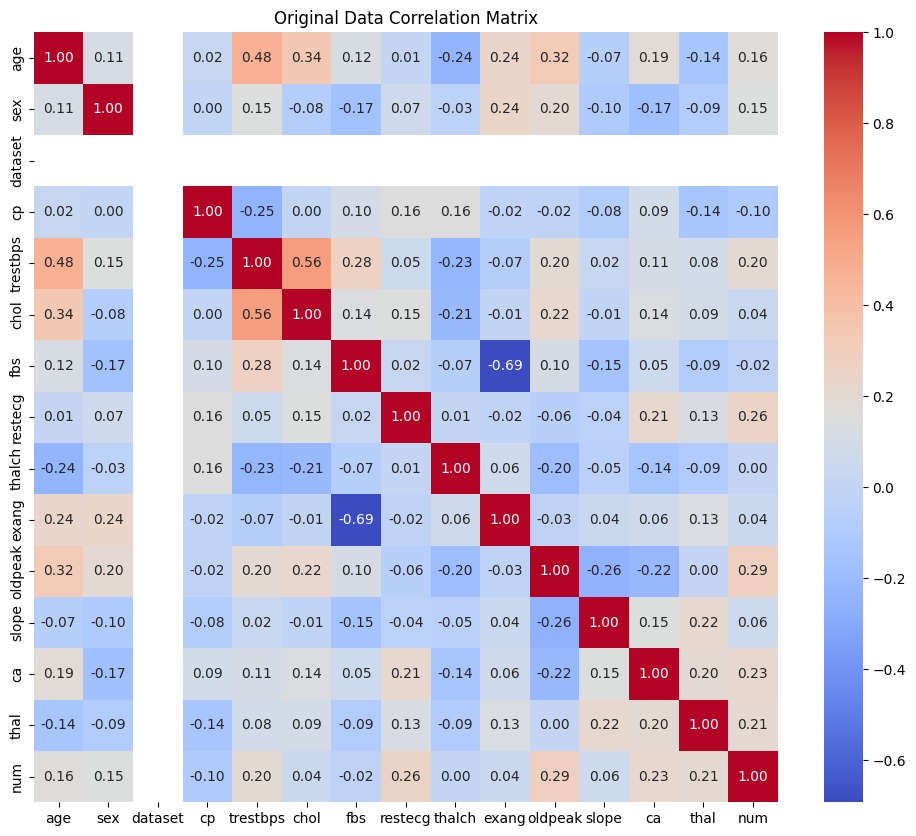

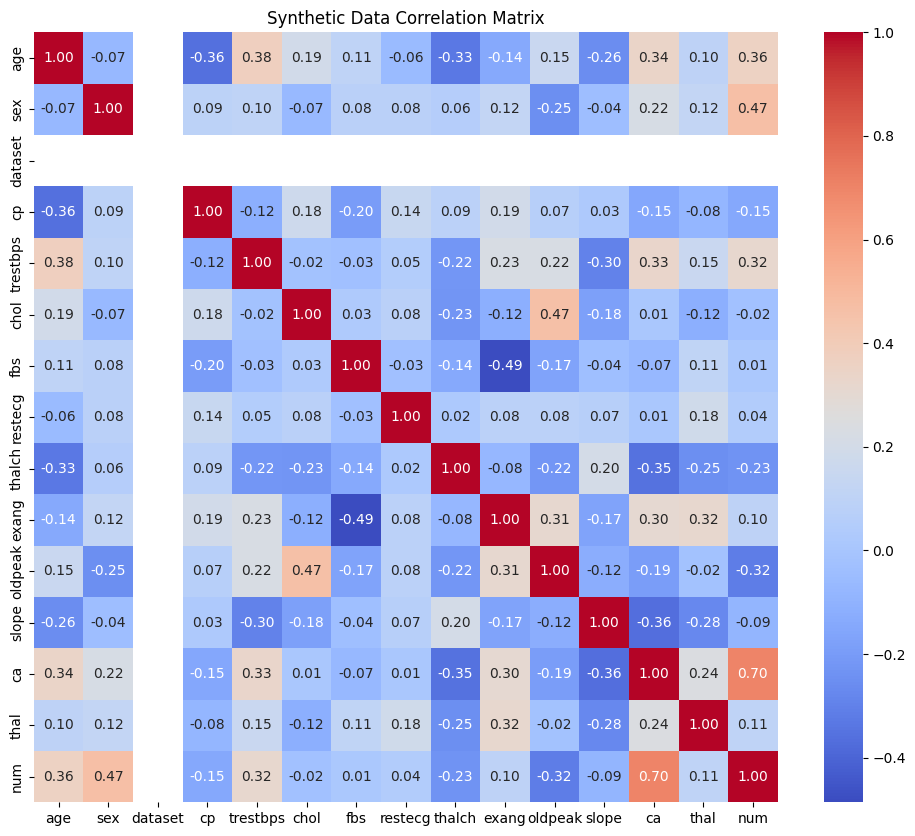

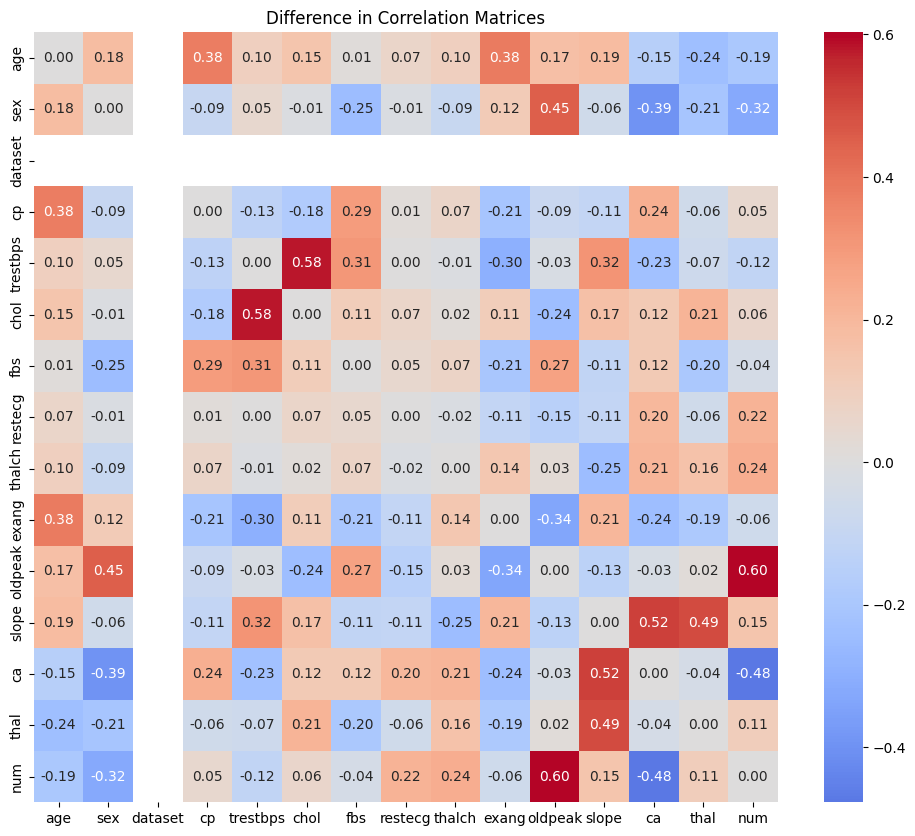

In [13]:
corr_original = original_processed.corr()
corr_synthetic = synthetic_processed.corr()
# Difference between the correlation matrices
corr_diff = corr_original - corr_synthetic
# Visualize the original correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_original, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Original Data Correlation Matrix')
plt.show()
# Visualize the synthetic correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_synthetic, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Synthetic Data Correlation Matrix')
plt.show()
# Visualize the difference
plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Difference in Correlation Matrices')
plt.show()


4) Distribution Comparison using Divergence measures

KL Divergence for sex: 0.2517937702572939
KL Divergence for cp: 6.7967828596149324
KL Divergence for restecg: 1.5478254957868565
KL Divergence for slope: 0.24563943635385166
KL Divergence for thal: 2.8852703895579466
KL Divergence for fbs: 0.025305350985260225
KL Divergence for exang: 0.16719485316481225


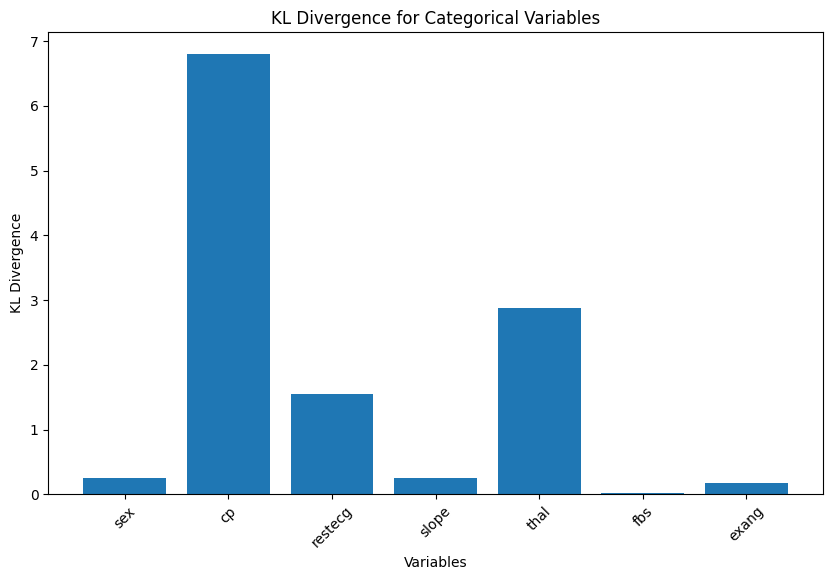

In [14]:
def compute_kl_divergence(p, q):
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    return np.sum(p * np.log(p / q))

kl_divergences = {}

for col in categorical_cols + binary_cols:
    orig_counts = original_processed[col].value_counts(normalize=True).sort_index()
    synth_counts = synthetic_processed[col].value_counts(normalize=True).sort_index()
    all_categories = orig_counts.index.union(synth_counts.index)
    p = orig_counts.reindex(all_categories, fill_value=0).values
    q = synth_counts.reindex(all_categories, fill_value=0).values
    kl_div = compute_kl_divergence(p, q)
    kl_divergences[col] = kl_div
    print(f"KL Divergence for {col}: {kl_div}")

# Plot KL Divergences
plt.figure(figsize=(10, 6))
plt.bar(kl_divergences.keys(), kl_divergences.values())
plt.title('KL Divergence for Categorical Variables')
plt.xlabel('Variables')
plt.ylabel('KL Divergence')
plt.xticks(rotation=45)
plt.show()

5) Coverage and Density Measure

In [15]:
numerical_features = numerical_cols

X_orig_num = original_processed[numerical_features].values
X_synth_num = synthetic_processed[numerical_features].values

def compute_coverage(X_train, X_synth, threshold=0.7):
    nbrs = NearestNeighbors(n_neighbors=1).fit(X_synth)
    distances, _ = nbrs.kneighbors(X_train)
    coverage = np.mean(distances <= threshold)
    return coverage

coverage_value = compute_coverage(X_orig_num, X_synth_num)
print(f"Coverage of synthetic data over original data: {coverage_value * 100:.2f}%")


Coverage of synthetic data over original data: 2.00%


6) Synthetic Data Utility Score (SDUS)

Synthetic Data Utility Score (SDUS): 0.0


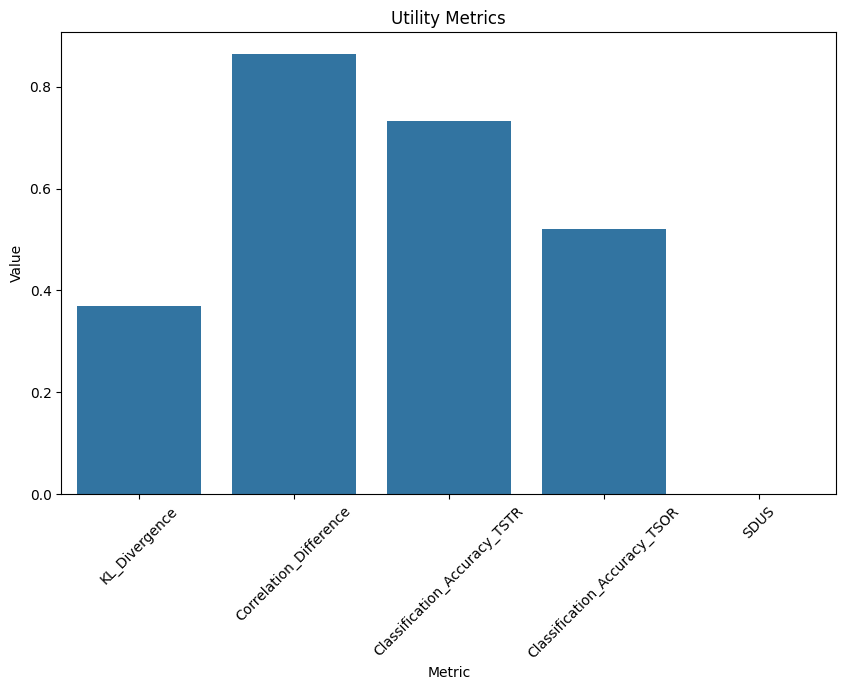

In [16]:
# Collect metrics
metrics_df = pd.DataFrame({
    'KL_Divergence': [np.mean(list(kl_divergences.values()))],
    'Correlation_Difference': [corr_diff.abs().mean().mean()],  # Mean absolute difference
    'Classification_Accuracy_TSTR': [classification_report(y_orig_test, y_pred_tstr, output_dict=True)['accuracy']],
    'Classification_Accuracy_TSOR': [classification_report(y_synth, y_pred_tsor, output_dict=True)['accuracy']]
})

# Normalize metrics (assuming lower is better for divergence and difference metrics)
metrics_df['KL_Divergence'] = 1 / (1 + metrics_df['KL_Divergence'])
metrics_df['Correlation_Difference'] = 1 / (1 + metrics_df['Correlation_Difference'])

# Combine metrics
metrics_normalized = MinMaxScaler().fit_transform(metrics_df)
sdus = metrics_normalized.mean(axis=1)[0]
print(f"Synthetic Data Utility Score (SDUS): {sdus}")

# Plot the utility metrics
metrics_df_plot = metrics_df.copy()
metrics_df_plot['SDUS'] = sdus

metrics_df_plot_melted = metrics_df_plot.melt(var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df_plot_melted, x='Metric', y='Value')
plt.title('Utility Metrics')
plt.xticks(rotation=45)
plt.show()

### Chain of Thought Synthetic Data Evaluation

In [19]:
# Define column types
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']
binary_cols = ['fbs', 'exang']

# Ensure consistent data types
for col in binary_cols:
    df[col] = df[col].astype(bool)
    df_CoT[col] = df_CoT[col].astype(bool)

# Preprocessing: Encode categorical variables
def preprocess_data(df):
    df_processed = df.copy()
    le_dict = {}
    for col in df_processed.columns:
        if df_processed[col].dtype == 'object' or df_processed[col].dtype == 'bool':
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col].astype(str))
            le_dict[col] = le
    return df_processed, le_dict

original_processed, le_dict_original = preprocess_data(df)
synthetic_processed, le_dict_synthetic = preprocess_data(df_CoT)

# Ensure columns are in the same order
synthetic_processed = synthetic_processed[original_processed.columns]


1) Kolmogorov-Smirnov Test and Wasserstein Distance for Numerical Variables

/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/2951217522.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_df[col], label='Original', shade=True)
/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/2951217522.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_CoT[col], label='Synthetic', shade=True)


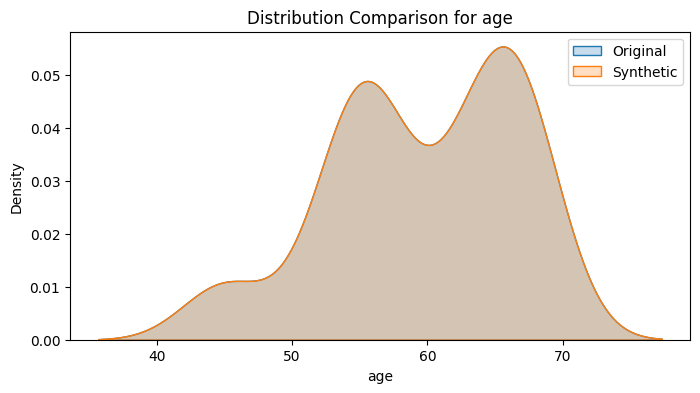

/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/2951217522.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_df[col], label='Original', shade=True)
/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/2951217522.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_CoT[col], label='Synthetic', shade=True)


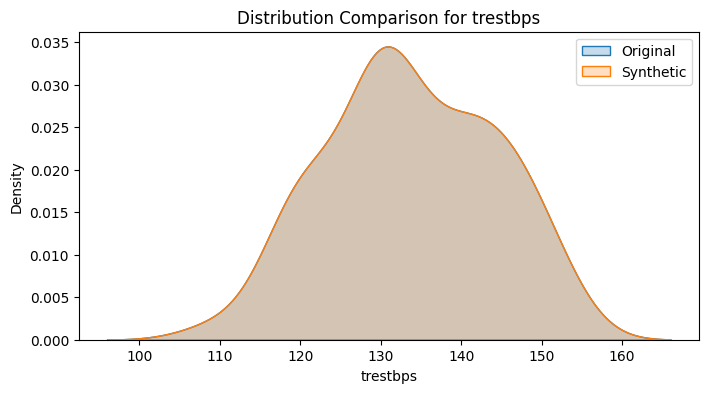

/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/2951217522.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_df[col], label='Original', shade=True)
/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/2951217522.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_CoT[col], label='Synthetic', shade=True)


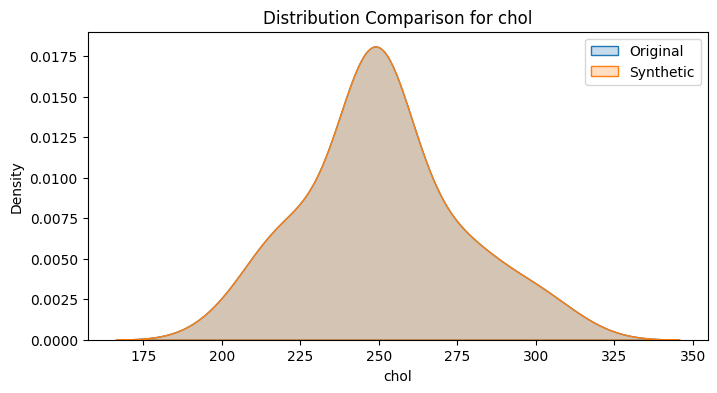

/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/2951217522.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_df[col], label='Original', shade=True)
/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/2951217522.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_CoT[col], label='Synthetic', shade=True)


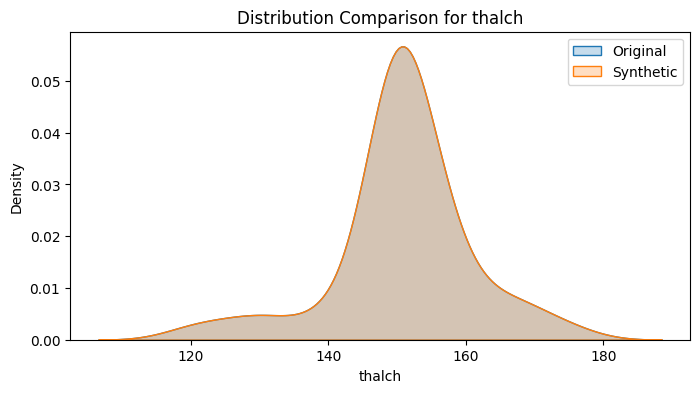

/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/2951217522.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_df[col], label='Original', shade=True)
/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/2951217522.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_CoT[col], label='Synthetic', shade=True)


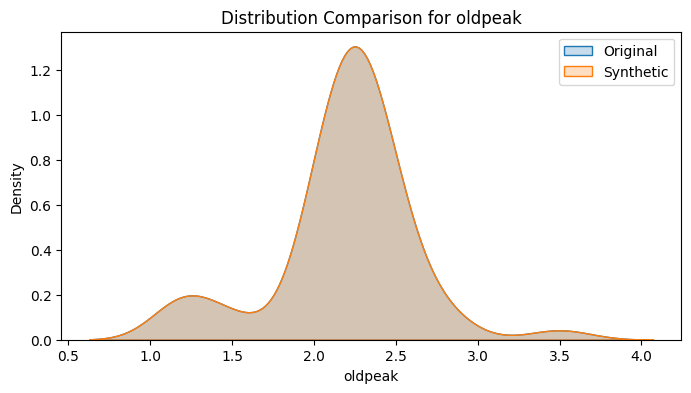

/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/2951217522.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_df[col], label='Original', shade=True)
/var/folders/4b/wkmzzw491mn72lffb7z9ps700000gn/T/ipykernel_83632/2951217522.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_CoT[col], label='Synthetic', shade=True)


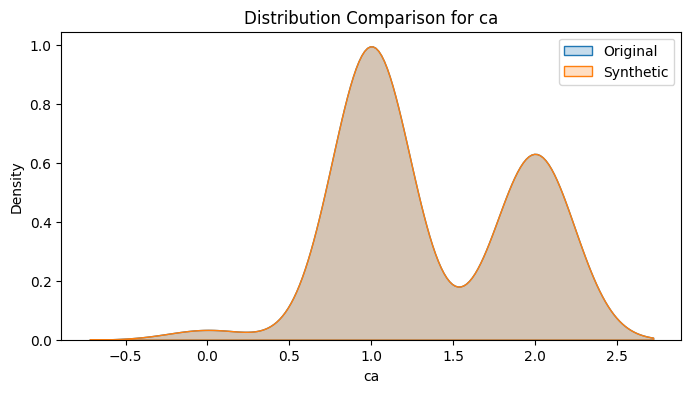

     Column  KS Statistic  KS p-value  Wasserstein Distance
0       age           0.0         1.0                   0.0
1  trestbps           0.0         1.0                   0.0
2      chol           0.0         1.0                   0.0
3    thalch           0.0         1.0                   0.0
4   oldpeak           0.0         1.0                   0.0
5        ca           0.0         1.0                   0.0


In [20]:
def compare_numerical_distributions(original_df, df_CoT, columns):
    distribution_metrics = []
    for col in columns:
        ks_stat, ks_p_value = ks_2samp(original_df[col], df_CoT[col])
        wd = wasserstein_distance(original_df[col], df_CoT[col])
        distribution_metrics.append({
            'Column': col,
            'KS Statistic': ks_stat,
            'KS p-value': ks_p_value,
            'Wasserstein Distance': wd
        })
        # Plot distributions
        plt.figure(figsize=(8, 4))
        sns.kdeplot(original_df[col], label='Original', shade=True)
        sns.kdeplot(df_CoT[col], label='Synthetic', shade=True)
        plt.title(f'Distribution Comparison for {col}')
        plt.legend()
        plt.show()
    return pd.DataFrame(distribution_metrics)

numerical_distribution_metrics = compare_numerical_distributions(
    original_processed, synthetic_processed, numerical_cols)
print(numerical_distribution_metrics)

In [ ]:
# Define column types
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']
binary_cols = ['fbs', 'exang']

# Ensure consistent data types
for col in binary_cols:
    df[col] = df[col].astype(bool)
    df_CoT[col] = df_CoT[col].astype(bool)

# Preprocessing: Encode categorical variables
def preprocess_data(df):
    df_processed = df.copy()
    le_dict = {}
    for col in df_processed.columns:
        if df_processed[col].dtype == 'object' or df_processed[col].dtype == 'bool':
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col].astype(str))
            le_dict[col] = le
    return df_processed, le_dict

original_processed, le_dict_original = preprocess_data(df)
synthetic_processed, le_dict_synthetic = preprocess_data(df_CoT)

# Ensure columns are in the same order
synthetic_processed = synthetic_processed[original_processed.columns]


2) Machine Learning Utility Metrics
a. Train on Synthetic, Test on Original
b. Train on Original, Test on Synthetic

TRAIN ON SYNTHETIC, TEST ON ORIGINAL Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        11

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

TRAIN ON ORIGINAL, TEST ON SYNTHETIC Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        22
           1       0.96      0.93      0.95        28

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50



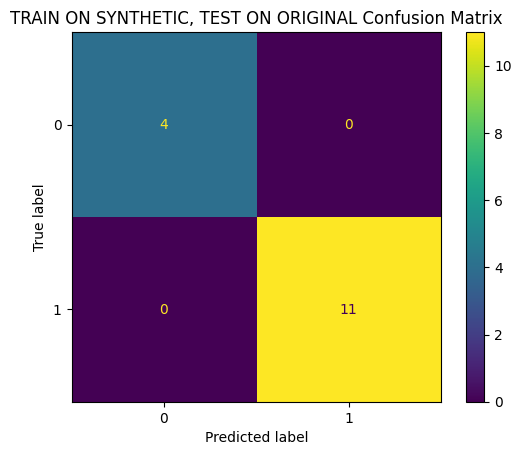

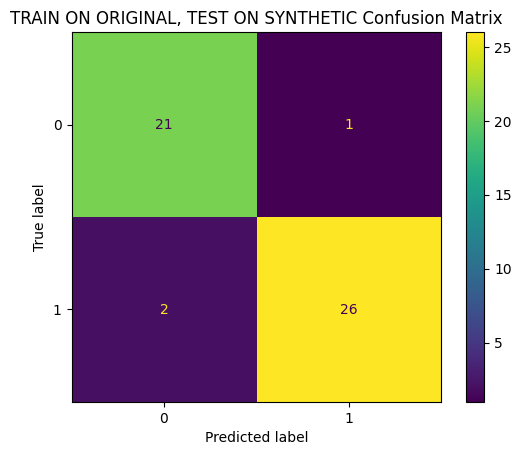

In [21]:
# Define target and features
target_column = 'num'
feature_columns = [col for col in original_processed.columns if col != target_column]

# Split the original data
X_orig = original_processed[feature_columns]
y_orig = original_processed[target_column]
X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(
    X_orig, y_orig, test_size=0.3, random_state=42)

# Prepare synthetic data
X_synth = synthetic_processed[feature_columns]
y_synth = synthetic_processed[target_column]

# TSTR: Train on Synthetic, Test on Original
model_tstr = RandomForestClassifier(n_estimators=100, random_state=42)
model_tstr.fit(X_synth, y_synth)
y_pred_tstr = model_tstr.predict(X_orig_test)
print("TRAIN ON SYNTHETIC, TEST ON ORIGINAL Evaluation:")
print(classification_report(y_orig_test, y_pred_tstr))

# TSOR: Train on Original, Test on Synthetic
model_tsor = RandomForestClassifier(n_estimators=100, random_state=42)
model_tsor.fit(X_orig_train, y_orig_train)
y_pred_tsor = model_tsor.predict(X_synth)
print("TRAIN ON ORIGINAL, TEST ON SYNTHETIC Evaluation:")
print(classification_report(y_synth, y_pred_tsor))

# Plot confusion matrices
# TSTR Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_orig_test, y_pred_tstr)
plt.title('TRAIN ON SYNTHETIC, TEST ON ORIGINAL Confusion Matrix')
plt.show()

# TSOR Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_synth, y_pred_tsor)
plt.title('TRAIN ON ORIGINAL, TEST ON SYNTHETIC Confusion Matrix')
plt.show()

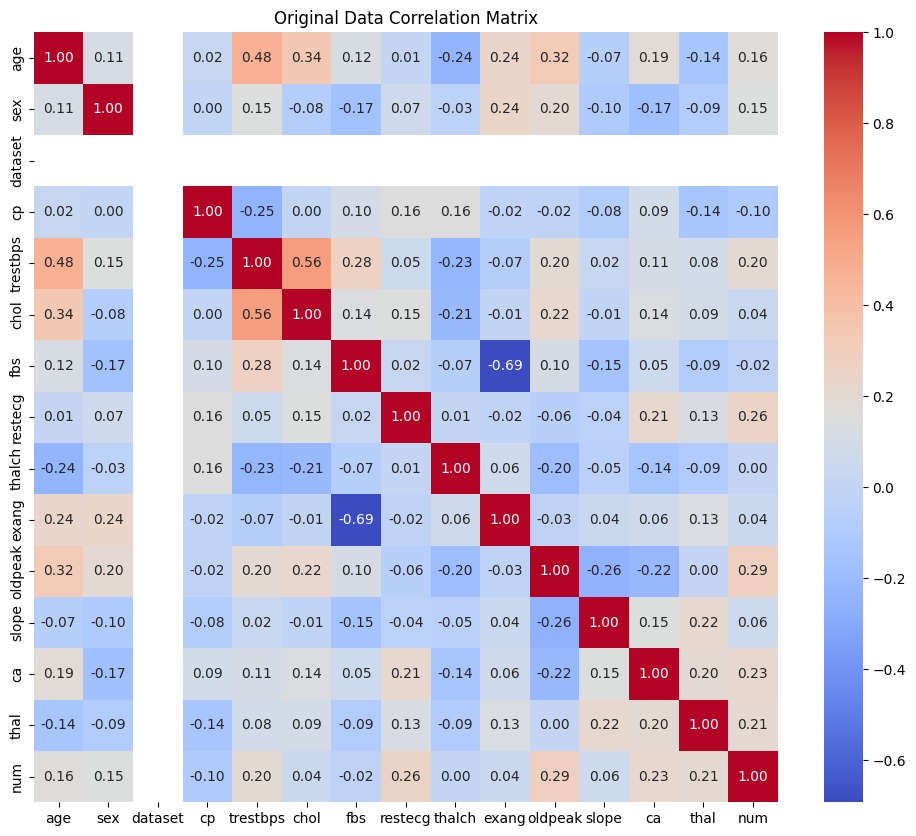

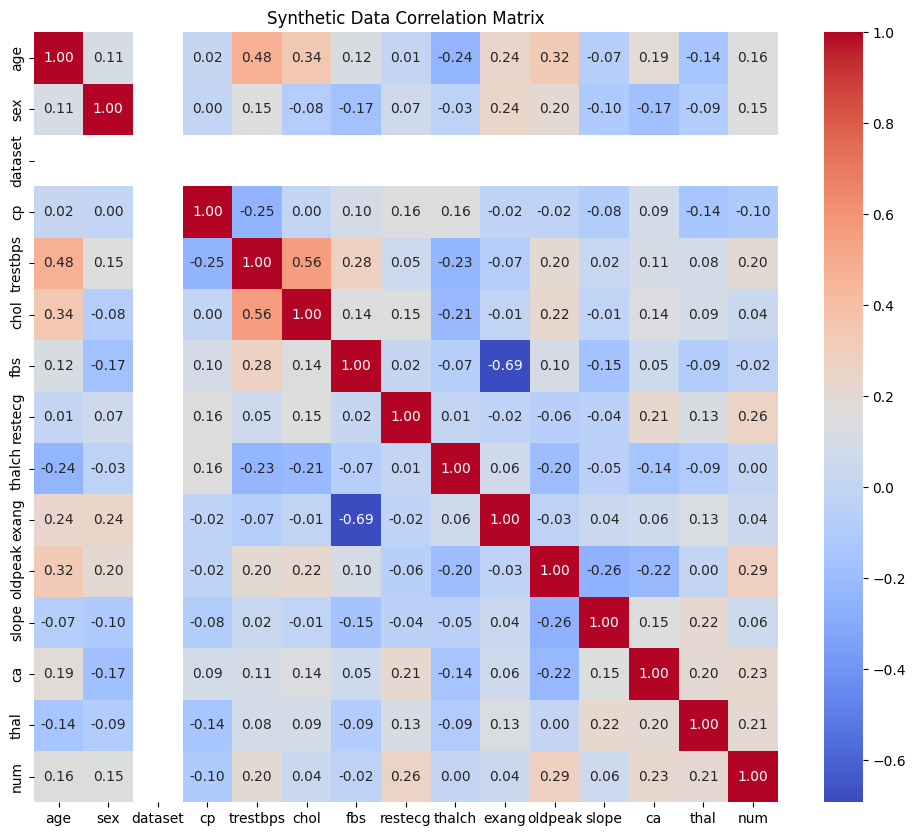

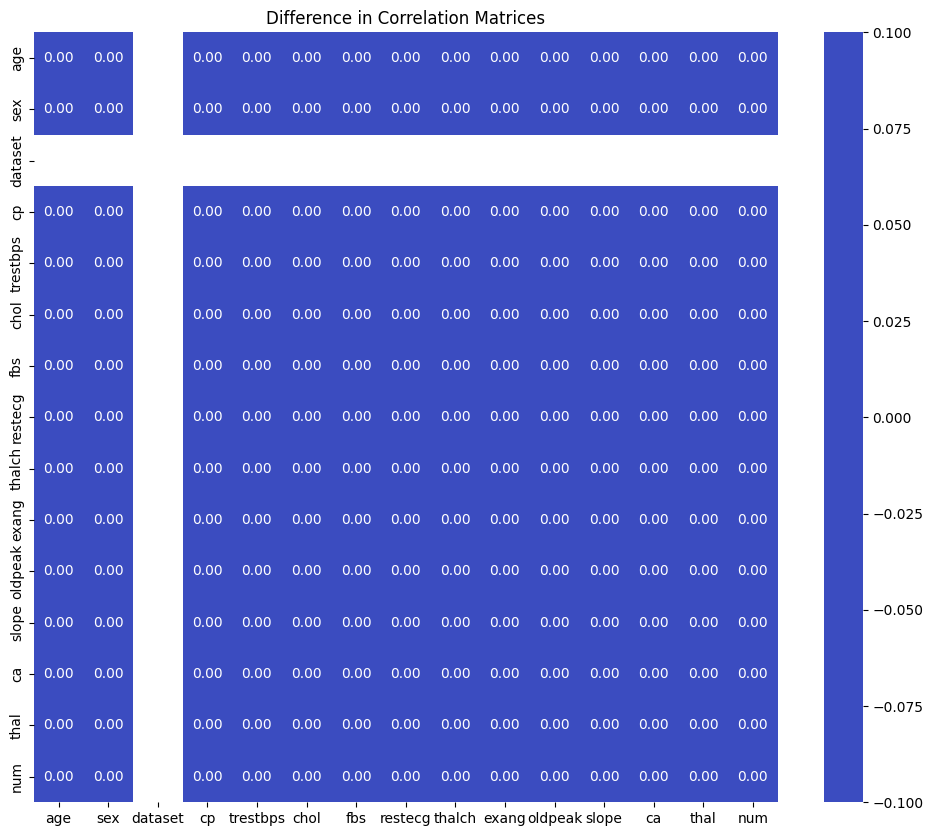

In [22]:
corr_original = original_processed.corr()
corr_synthetic = synthetic_processed.corr()
# Difference between the correlation matrices
corr_diff = corr_original - corr_synthetic
# Visualize the original correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_original, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Original Data Correlation Matrix')
plt.show()
# Visualize the synthetic correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_synthetic, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Synthetic Data Correlation Matrix')
plt.show()
# Visualize the difference
plt.figure(figsize=(12, 10))
sns.heatmap(corr_diff, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Difference in Correlation Matrices')
plt.show()


4) Distribution Comparison using Divergence measures

KL Divergence for sex: 0.0
KL Divergence for cp: 0.0
KL Divergence for restecg: 0.0
KL Divergence for slope: 0.0
KL Divergence for thal: 0.0
KL Divergence for fbs: 0.0
KL Divergence for exang: 0.0


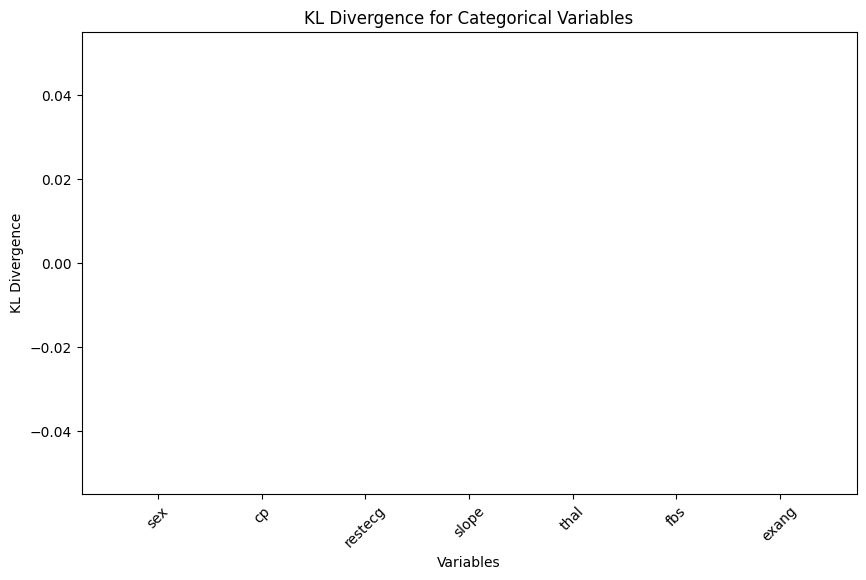

In [23]:
def compute_kl_divergence(p, q):
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    return np.sum(p * np.log(p / q))

kl_divergences = {}

for col in categorical_cols + binary_cols:
    orig_counts = original_processed[col].value_counts(normalize=True).sort_index()
    synth_counts = synthetic_processed[col].value_counts(normalize=True).sort_index()
    all_categories = orig_counts.index.union(synth_counts.index)
    p = orig_counts.reindex(all_categories, fill_value=0).values
    q = synth_counts.reindex(all_categories, fill_value=0).values
    kl_div = compute_kl_divergence(p, q)
    kl_divergences[col] = kl_div
    print(f"KL Divergence for {col}: {kl_div}")

# Plot KL Divergences
plt.figure(figsize=(10, 6))
plt.bar(kl_divergences.keys(), kl_divergences.values())
plt.title('KL Divergence for Categorical Variables')
plt.xlabel('Variables')
plt.ylabel('KL Divergence')
plt.xticks(rotation=45)
plt.show()

5) Coverage and Density Measure

In [24]:
numerical_features = numerical_cols

X_orig_num = original_processed[numerical_features].values
X_synth_num = synthetic_processed[numerical_features].values

def compute_coverage(X_train, X_synth, threshold=0.7):
    nbrs = NearestNeighbors(n_neighbors=1).fit(X_synth)
    distances, _ = nbrs.kneighbors(X_train)
    coverage = np.mean(distances <= threshold)
    return coverage

coverage_value = compute_coverage(X_orig_num, X_synth_num)
print(f"Coverage of synthetic data over original data: {coverage_value * 100:.2f}%")


Coverage of synthetic data over original data: 100.00%


6) Synthetic Data Utility Score (SDUS)

Synthetic Data Utility Score (SDUS): 0.0


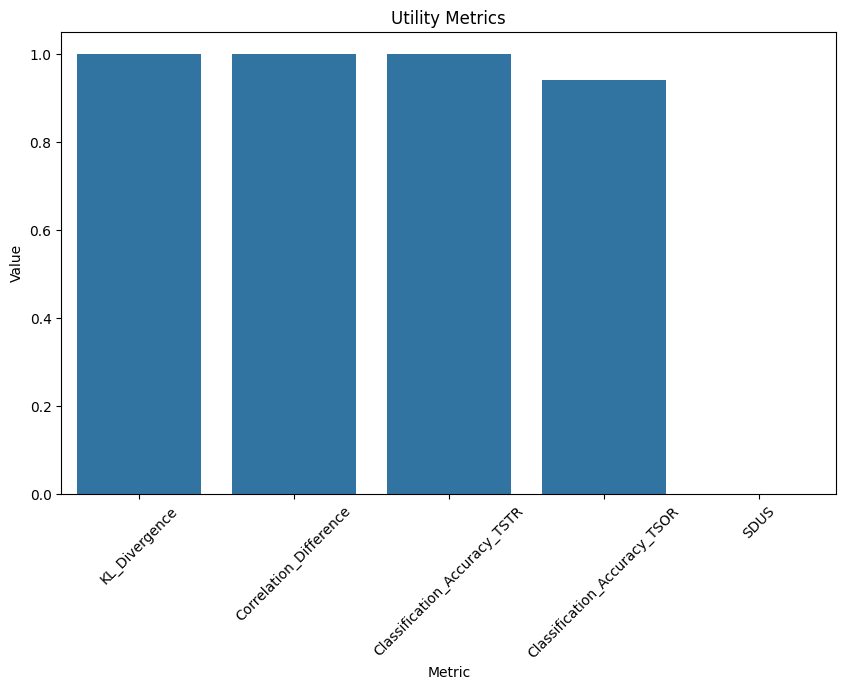

In [25]:
# Collect metrics
metrics_df = pd.DataFrame({
    'KL_Divergence': [np.mean(list(kl_divergences.values()))],
    'Correlation_Difference': [corr_diff.abs().mean().mean()],  # Mean absolute difference
    'Classification_Accuracy_TSTR': [classification_report(y_orig_test, y_pred_tstr, output_dict=True)['accuracy']],
    'Classification_Accuracy_TSOR': [classification_report(y_synth, y_pred_tsor, output_dict=True)['accuracy']]
})

# Normalize metrics (assuming lower is better for divergence and difference metrics)
metrics_df['KL_Divergence'] = 1 / (1 + metrics_df['KL_Divergence'])
metrics_df['Correlation_Difference'] = 1 / (1 + metrics_df['Correlation_Difference'])

# Combine metrics
metrics_normalized = MinMaxScaler().fit_transform(metrics_df)
sdus = metrics_normalized.mean(axis=1)[0]
print(f"Synthetic Data Utility Score (SDUS): {sdus}")

# Plot the utility metrics
metrics_df_plot = metrics_df.copy()
metrics_df_plot['SDUS'] = sdus

metrics_df_plot_melted = metrics_df_plot.melt(var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df_plot_melted, x='Metric', y='Value')
plt.title('Utility Metrics')
plt.xticks(rotation=45)
plt.show()